# Project One: Loan Approval Rates and Influencing Factors in India
## Original Submission + Machine Learing Exercise

## Loading Modules

In [1]:
# Dependencies
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import csv
import seaborn as sns
from collections import Counter

import statistics as stats

from numpy.random import seed

import seaborn as sns; sns.set()
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind_from_stats


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

#below will help understand the accuracy of the model
#F1 score, if within 75-90 percent range, then acceptable
from sklearn.metrics import classification_report

import os

import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


## Importing Data

In [2]:
# Read application_data csv file
# Create application DataFrame

app_data = "application_data.csv"
application = pd.read_csv(app_data)
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Read previous_application csv file
# Create previous DataFrame

previous_app_data = "previous_application.csv"
previous_app = pd.read_csv(previous_app_data)
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [4]:
# Create new application_data file for selected columns only

appdata = application[["SK_ID_CURR", 
                        "TARGET",
                        "NAME_CONTRACT_TYPE",
                        "CODE_GENDER",
                        "FLAG_OWN_CAR",
                        "FLAG_OWN_REALTY",
                        "CNT_CHILDREN",
                        "AMT_INCOME_TOTAL",
                        "AMT_CREDIT",
                        "AMT_ANNUITY",
                        "AMT_GOODS_PRICE",
                        "NAME_INCOME_TYPE",
                        "NAME_EDUCATION_TYPE",
                        "NAME_FAMILY_STATUS",
                        "NAME_HOUSING_TYPE",
                        "REGION_POPULATION_RELATIVE",
                        "DAYS_BIRTH",
                        "OCCUPATION_TYPE",
                        "CNT_FAM_MEMBERS",
                        "REGION_RATING_CLIENT",
                        "WEEKDAY_APPR_PROCESS_START",
                        "ORGANIZATION_TYPE",
                        "OBS_30_CNT_SOCIAL_CIRCLE",
                        "DEF_30_CNT_SOCIAL_CIRCLE",
                        "OBS_60_CNT_SOCIAL_CIRCLE",
                        "DEF_60_CNT_SOCIAL_CIRCLE",
                        "AMT_REQ_CREDIT_BUREAU_MON",
                        "AMT_REQ_CREDIT_BUREAU_QRT",
                        "AMT_REQ_CREDIT_BUREAU_YEAR"]]

In [5]:
# Rename applications data columns - before merge
# Add 'CURR' to the column heading to denote the original application_data file

clean_appdata = appdata.rename(columns={"TARGET": "CURR_TARGET",
                                        "NAME_CONTRACT_TYPE": "CURR_NAME_CONTRACT_TYPE",
                                        "CODE_GENDER": "CURR_CODE_GENDER",
                                        "FLAG_OWN_CAR": "CURR_FLAG_OWN_CAR",
                                        "FLAG_OWN_REALTY": "CURR_FLAG_OWN_REALTY",
                                        "CNT_CHILDREN": "CURR_CNT_CHILDREN",
                                        "AMT_INCOME_TOTAL": "CURR_AMT_INCOME_TOTAL",
                                        "AMT_CREDIT": "CURR_AMT_CREDIT",
                                        "AMT_ANNUITY": "CURR_AMT_ANNUITY",
                                        "AMT_GOODS_PRICE": "CURR_AMT_GOODS_PRICE",
                                        "NAME_INCOME_TYPE": "CURR_NAME_INCOME_TYPE",
                                        "NAME_EDUCATION_TYPE": "CURR_NAME_EDUCATION_TYPE",
                                        "NAME_FAMILY_STATUS": "CURR_NAME_FAMILY_STATUS",
                                        "NAME_HOUSING_TYPE": "CURR_NAME_HOUSING_TYPE",
                                        "REGION_POPULATION_RELATIVE": "CURR_REGION_POPULATION_RELATIVE",
                                        "DAYS_BIRTH": "CURR_DAYS_BIRTH",
                                        "OCCUPATION_TYPE": "CURR_OCCUPATION_TYPE",
                                        "CNT_FAM_MEMBERS": "CURR_CNT_FAM_MEMBERS",
                                        "REGION_RATING_CLIENT": "CURR_REGION_RATING_CLIENT",
                                        "WEEKDAY_APPR_PROCESS_START": "CURR_WEEKDAY_APPR_PROCESS_START",
                                        "ORGANIZATION_TYPE": "CURR_ORGANIZATION_TYPE",
                                        "OBS_30_CNT_SOCIAL_CIRCLE": "CURR_OBS_30_CNT_SOCIAL_CIRCLE",
                                        "DEF_30_CNT_SOCIAL_CIRCLE": "CURR_DEF_30_CNT_SOCIAL_CIRCLE",
                                        "OBS_60_CNT_SOCIAL_CIRCLE": "CURR_OBS_60_SOCIAL_CIRCLE",
                                        "DEF_60_CNT_SOCIAL_CIRCLE": "CURR_DEF_60_SOCIAL_CIRCLE",
                                        "AMT_REQ_CREDIT_BUREAU_MON": "CURR_AMT_REQ_CREDIT_BUREAU_MON",
                                        "AMT_REQ_CREDIT_BUREAU_QRT": "CURR_AMT_REQ_CREDIT_BUREAU_MON",
                                        "AMT_REQ_CREDIT_BUREAU_YEAR": "CURR_AMT_REQ_CREDIT_BUREAU_YEAR" 
                                       })

In [6]:
# Create previous_application_data file with with selected columns

prevdata = previous_app[["SK_ID_PREV",
                        "SK_ID_CURR",
                        "NAME_CONTRACT_TYPE",
                        "AMT_ANNUITY",
                        "AMT_APPLICATION",
                        "AMT_CREDIT",
                        "AMT_DOWN_PAYMENT",
                        "AMT_GOODS_PRICE",
                        "WEEKDAY_APPR_PROCESS_START",
                        "NFLAG_LAST_APPL_IN_DAY",
                        "NAME_CASH_LOAN_PURPOSE",
                        "NAME_CONTRACT_STATUS",
                        "DAYS_DECISION",
                        "CODE_REJECT_REASON",
                        "NAME_CLIENT_TYPE",
                        "NAME_GOODS_CATEGORY",
                        "NAME_PORTFOLIO",
                        "NAME_PRODUCT_TYPE",
                        "CHANNEL_TYPE",
                        "NAME_SELLER_INDUSTRY",
                        "NAME_YIELD_GROUP",
                        "PRODUCT_COMBINATION",
                        "DAYS_FIRST_DRAWING",
                        "DAYS_FIRST_DUE",
                        "DAYS_LAST_DUE_1ST_VERSION",
                        "DAYS_LAST_DUE",
                        "DAYS_TERMINATION",
                        "NFLAG_INSURED_ON_APPROVAL"]]

In [7]:
# Rename the columns for previous_application_data
# Add 'PREV' to the column heading to denote the original previous file

clean_prevdata = prevdata.rename(columns={"SK_ID_PREV": "PREV_SK_ID_PREV",
                                    "NAME_CONTRACT_TYPE": "PREV_NAME_CONTRACT_TYPE",
                                    "AMT_ANNUITY": "PREV_AMT_ANNUITY",
                                    "AMT_APPLICATION": "PREV_AMT_APPLICATION",
                                    "AMT_CREDIT": "PREV_AMT_CREDIT",
                                    "AMT_DOWN_PAYMENT": "PREV_AMT_DOWN_PAYMENT",
                                    "AMT_GOODS_PRICE": "PREV_AMT_GOODS_PRICE",
                                    "WEEKDAY_APPR_PROCESS_START": "PREV_WEEKDAY_APPR_PROCESS_START",
                                    "NFLAG_LAST_APPL_IN_DAY": "PREV_NFLAG_LAST_APPL_IN_DAY",
                                    "NAME_CASH_LOAN_PURPOSE": "PREV_NAME_CASH_LOAN_PURPOSE",
                                    "NAME_CONTRACT_STATUS": "PREV_NAME_CONTRACT_STATUS",
                                    "DAYS_DECISION": "PREV_DAYS_DECISION",
                                    "CODE_REJECT_REASON": "PREV_CODE_REJECT_REASON",
                                    "NAME_CLIENT_TYPE": "PREV_NAME_CLIENT",
                                    "NAME_GOODS_CATEGORY": "PREV_NAME_GOODS_CATEGORY",
                                    "NAME_PORTFOLIO": "PREV_NAME_PORTFOLIO",
                                    "NAME_PRODUCT_TYPE": "PREV_NAME_PRODUCT_TYPE",
                                    "CHANNEL_TYPE": "PREV_CHANNEL_TYPE",
                                    "NAME_SELLER_INDUSTRY": "PREV_NAME_SELLER_INDUSTRY",
                                    "NAME_YIELD_GROUP": "PREV_NAME_YIELD_GROUP",
                                    "PRODUCT_COMBINATION": "PREV_PRODUCT_COMBINATION",
                                    "DAYS_FIRST_DRAWING": "PREV_DAYS_FIRST_DRAWING",
                                    "DAYS_FIRST_DUE": "PREV_DAYS_FIRST_DUE",
                                    "DAYS_LAST_DUE_1ST_VERSION": "PREV_DAYS_LAST_DUE_1ST_VERSION",
                                    "DAYS_LAST_DUE": "PREV_DAYS_LAST_DUE",
                                    "DAYS_TERMINATION": "PREV_DAYS_TERMINATION",
                                    "NFLAG_INSURED_ON_APPROVAL": "PREV_NFLAG_INSURED_ON_APPROVAL"    
                                         })

In [8]:
# Create one dataframe
# Merge clean_appdata and clean_prevdata
loan_data = pd.merge(clean_appdata, clean_prevdata, on='SK_ID_CURR', how='inner')
loan_data.head()

,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,PREV_CHANNEL_TYPE,PREV_NAME_SELLER_INDUSTRY,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Stone,Auto technology,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Stone,Furniture,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Country-wide,Consumer electronics,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Regional / Local,Connectivity,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [9]:
# Check Unique SK_ID_CURR

sk_id_count = loan_data["SK_ID_CURR"].nunique()
print(sk_id_count)

291057


In [10]:
# Check for duplicates on SK_ID_CURR series
loan_data.loc[loan_data[['SK_ID_CURR']].duplicated(keep='first'), :]

,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,PREV_CHANNEL_TYPE,PREV_NAME_SELLER_INDUSTRY,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Stone,Furniture,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Country-wide,Consumer electronics,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
6,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Credit and cash offices,XNA,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
7,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Country-wide,Consumer electronics,high,POS household with interest,365243.0,-281.0,49.0,365243.0,365243.0,0.0
8,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Credit and cash offices,XNA,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413696,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,Credit and cash offices,XNA,middle,Cash X-Sell: middle,365243.0,-618.0,72.0,-558.0,-528.0,1.0
1413697,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,Country-wide,Connectivity,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1413698,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,Credit and cash offices,XNA,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
1413699,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,AP+ (Cash loan),XNA,low_normal,Cash X-Sell: low,365243.0,-756.0,294.0,-66.0,-64.0,0.0


In [11]:
# Create a clean DataFrame by dropping the duplicates on series SK_ID_CURR. Use .drop_duplicates()

clean_loan_data = loan_data.drop_duplicates(subset=['SK_ID_CURR'])

In [12]:
clean_loan_data.head(10)

,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,PREV_CHANNEL_TYPE,PREV_NAME_SELLER_INDUSTRY,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Stone,Auto technology,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Regional / Local,Connectivity,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
5,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0
14,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,Regional / Local,Consumer electronics,high,Cash Street: high,365243.0,-834.0,-324.0,-354.0,-347.0,0.0
20,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,Country-wide,Consumer electronics,low_normal,POS household with interest,365243.0,-339.0,-69.0,-69.0,-66.0,0.0
25,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,Regional / Local,Consumer electronics,low_action,POS household without interest,365243.0,-418.0,-88.0,-88.0,-84.0,0.0
32,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,Stone,Furniture,low_action,POS industry without interest,365243.0,-1039.0,-769.0,-769.0,-762.0,0.0
33,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,Credit and cash offices,XNA,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
37,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,Country-wide,Connectivity,high,POS mobile with interest,365243.0,-1641.0,-1311.0,-1401.0,-1397.0,0.0


In [13]:
# Calculate loan applicant age based on CURR_DAYS_BIRTH series
# Add column for AGE
clean_loan_data['CURR_DAYS_BIRTH'].astype(float)
age = clean_loan_data['CURR_DAYS_BIRTH'] / -365
clean_loan_data['AGE'] = round(clean_loan_data['CURR_DAYS_BIRTH'] / -365, 0)


C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
# Create Bins for Age
bins = [20, 31, 40, 50, 60, 70]
group_names = ["< 30", "31-40", "41-50", "51-60", "61 +"]

clean_loan_data["AGE RANGE"] = pd.cut(clean_loan_data["AGE"], bins, labels=group_names, include_lowest=True)


C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Let's take a look at how many missing values we have

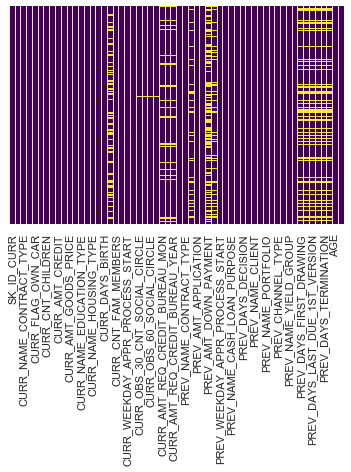

In [15]:
sns.heatmap(clean_loan_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')



In [16]:
#lets get rid of the missing values
clean_loan_data.isna().sum()

SK_ID_CURR                              0
CURR_TARGET                             0
CURR_NAME_CONTRACT_TYPE                 0
CURR_CODE_GENDER                        0
CURR_FLAG_OWN_CAR                       0
CURR_FLAG_OWN_REALTY                    0
CURR_CNT_CHILDREN                       0
CURR_AMT_INCOME_TOTAL                   0
CURR_AMT_CREDIT                         0
CURR_AMT_ANNUITY                       12
CURR_AMT_GOODS_PRICE                  267
CURR_NAME_INCOME_TYPE                   0
CURR_NAME_EDUCATION_TYPE                0
CURR_NAME_FAMILY_STATUS                 0
CURR_NAME_HOUSING_TYPE                  0
CURR_REGION_POPULATION_RELATIVE         0
CURR_DAYS_BIRTH                         0
CURR_OCCUPATION_TYPE                91240
CURR_CNT_FAM_MEMBERS                    0
CURR_REGION_RATING_CLIENT               0
CURR_WEEKDAY_APPR_PROCESS_START         0
CURR_ORGANIZATION_TYPE                  0
CURR_OBS_30_CNT_SOCIAL_CIRCLE         774
CURR_DEF_30_CNT_SOCIAL_CIRCLE     

### Let's replace the missing values with zero for annuity amount given there are so few values missing

In [91]:
clean_loan_data['CURR_AMT_ANNUITY'] = clean_loan_data['CURR_AMT_ANNUITY'].fillna(value = 0)

C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Let's check the missing values again

In [18]:

clean_loan_data.isna().sum()

SK_ID_CURR                              0
CURR_TARGET                             0
CURR_NAME_CONTRACT_TYPE                 0
CURR_CODE_GENDER                        0
CURR_FLAG_OWN_CAR                       0
CURR_FLAG_OWN_REALTY                    0
CURR_CNT_CHILDREN                       0
CURR_AMT_INCOME_TOTAL                   0
CURR_AMT_CREDIT                         0
CURR_AMT_ANNUITY                        0
CURR_AMT_GOODS_PRICE                  267
CURR_NAME_INCOME_TYPE                   0
CURR_NAME_EDUCATION_TYPE                0
CURR_NAME_FAMILY_STATUS                 0
CURR_NAME_HOUSING_TYPE                  0
CURR_REGION_POPULATION_RELATIVE         0
CURR_DAYS_BIRTH                         0
CURR_OCCUPATION_TYPE                91240
CURR_CNT_FAM_MEMBERS                    0
CURR_REGION_RATING_CLIENT               0
CURR_WEEKDAY_APPR_PROCESS_START         0
CURR_ORGANIZATION_TYPE                  0
CURR_OBS_30_CNT_SOCIAL_CIRCLE         774
CURR_DEF_30_CNT_SOCIAL_CIRCLE     

### Let's find a way to fill in these missing values for occupation type as this metric is key to our future models we will run. 

### We will see what occupation type is the most common accross each age bin, then we will apply that to the missing values in the clean_loan_data data frame.

### First we need to build a data frame to find the most common occupation type.

In [19]:


sidedf2 = clean_loan_data
sidedf2 = sidedf2.dropna()
sidedf2['CURR_OCCUPATION_TYPE'].value_counts()
sidedf2 = sidedf2.reset_index(drop=True)


In [20]:
#Now we will find the most common value in each column across each age bin

sidedf2.groupby(['AGE RANGE']).agg(mod  = ('CURR_OCCUPATION_TYPE', \
                                        lambda x: x.value_counts().index[0]),
                                        \
                                      )


,mod
AGE RANGE,
< 30,Laborers
31-40,Laborers
41-50,Laborers
51-60,Laborers
61 +,Laborers


### Now we can apply our findings above to the original missing values in the clean_loan_data dataframe.

### We will look at the rows with missing values in CURR_OCCUPATION_TYPE, reference the age bin associated and apply the corresponding most common occupation type.

### Because the most common type across all age bins in laborers we can do this very easily by replacing all NaN values with 'Laborers'.


In [21]:

clean_loan_data['CURR_OCCUPATION_TYPE'] = clean_loan_data['CURR_OCCUPATION_TYPE'].fillna(value = 'Laborers')


C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
#lets check the missing values again, any balance should not impact our Exploratory data Analysis
clean_loan_data.isna().sum()

SK_ID_CURR                              0
CURR_TARGET                             0
CURR_NAME_CONTRACT_TYPE                 0
CURR_CODE_GENDER                        0
CURR_FLAG_OWN_CAR                       0
CURR_FLAG_OWN_REALTY                    0
CURR_CNT_CHILDREN                       0
CURR_AMT_INCOME_TOTAL                   0
CURR_AMT_CREDIT                         0
CURR_AMT_ANNUITY                        0
CURR_AMT_GOODS_PRICE                  267
CURR_NAME_INCOME_TYPE                   0
CURR_NAME_EDUCATION_TYPE                0
CURR_NAME_FAMILY_STATUS                 0
CURR_NAME_HOUSING_TYPE                  0
CURR_REGION_POPULATION_RELATIVE         0
CURR_DAYS_BIRTH                         0
CURR_OCCUPATION_TYPE                    0
CURR_CNT_FAM_MEMBERS                    0
CURR_REGION_RATING_CLIENT               0
CURR_WEEKDAY_APPR_PROCESS_START         0
CURR_ORGANIZATION_TYPE                  0
CURR_OBS_30_CNT_SOCIAL_CIRCLE         774
CURR_DEF_30_CNT_SOCIAL_CIRCLE     

In [23]:
clean_loan_data.head(20)

,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL,AGE,AGE RANGE
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0,26.0,< 30
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0,46.0,41-50
4,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0,52.0,51-60
5,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0,52.0,51-60
14,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,high,Cash Street: high,365243.0,-834.0,-324.0,-354.0,-347.0,0.0,55.0,51-60
20,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,low_normal,POS household with interest,365243.0,-339.0,-69.0,-69.0,-66.0,0.0,46.0,41-50
25,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,low_action,POS household without interest,365243.0,-418.0,-88.0,-88.0,-84.0,0.0,38.0,31-40
32,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,low_action,POS industry without interest,365243.0,-1039.0,-769.0,-769.0,-762.0,0.0,52.0,51-60
33,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,55.0,51-60
37,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,high,POS mobile with interest,365243.0,-1641.0,-1311.0,-1401.0,-1397.0,0.0,40.0,31-40


In [24]:
clean_loan_data.count()

SK_ID_CURR                         291057
CURR_TARGET                        291057
CURR_NAME_CONTRACT_TYPE            291057
CURR_CODE_GENDER                   291057
CURR_FLAG_OWN_CAR                  291057
CURR_FLAG_OWN_REALTY               291057
CURR_CNT_CHILDREN                  291057
CURR_AMT_INCOME_TOTAL              291057
CURR_AMT_CREDIT                    291057
CURR_AMT_ANNUITY                   291057
CURR_AMT_GOODS_PRICE               290790
CURR_NAME_INCOME_TYPE              291057
CURR_NAME_EDUCATION_TYPE           291057
CURR_NAME_FAMILY_STATUS            291057
CURR_NAME_HOUSING_TYPE             291057
CURR_REGION_POPULATION_RELATIVE    291057
CURR_DAYS_BIRTH                    291057
CURR_OCCUPATION_TYPE               291057
CURR_CNT_FAM_MEMBERS               291057
CURR_REGION_RATING_CLIENT          291057
CURR_WEEKDAY_APPR_PROCESS_START    291057
CURR_ORGANIZATION_TYPE             291057
CURR_OBS_30_CNT_SOCIAL_CIRCLE      290283
CURR_DEF_30_CNT_SOCIAL_CIRCLE     

## Exploratory Data Analysis

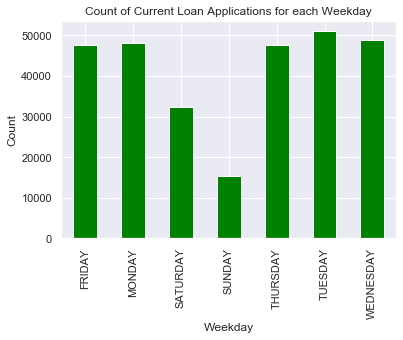

,CURR_WEEKDAY_APPR_PROCESS_START
CURR_WEEKDAY_APPR_PROCESS_START,
FRIDAY,47543
MONDAY,48040
SATURDAY,32311
SUNDAY,15462
THURSDAY,47723
TUESDAY,51017
WEDNESDAY,48961


In [25]:
#Creating a dataframe grouping by the column 'CURR_WEEKDAY_APPR_PROCESS_START'
days_group = clean_loan_data.groupby('CURR_WEEKDAY_APPR_PROCESS_START')

#Record count number of data points for each day
days_group_count = pd.DataFrame(days_group['CURR_WEEKDAY_APPR_PROCESS_START'].count())

#Bar chart based off of the group series
loan_weekdays_chart = days_group_count.plot(kind='bar', title="Count of Current Loan Applications for each Weekday", color="green", legend=None)

#xlabel and ylabels
loan_weekdays_chart.set_xlabel("Weekday")
loan_weekdays_chart.set_ylabel("Count")

plt.show()

#Display count values
days_group_count

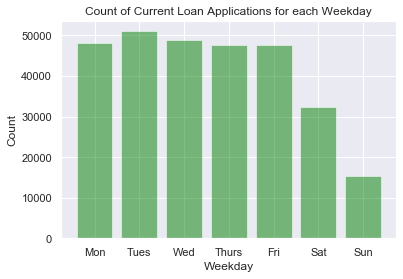

Most loan applications were submitted during the weekdays, with very few submissions on Sunday.


In [26]:
#Cleaning the "Count of Current Loan Applications for each Weekday" bar chart
#to display bar chart xlabels in the correct order of days of the week
cats = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_count_cats= [48040, 51017, 48961, 47723, 47543, 32311, 15462]

#Create a new bar plot based off of the group series
loan_weekdays_chart2=plt.bar(cats, day_count_cats, color='green', alpha=0.5, align='center')

#xlabel and ylabels
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.title("Count of Current Loan Applications for each Weekday")

#Save the figure
plt.savefig("Images/AppsbyWeekdayBarChart.png")

plt.show()

print(f"Most loan applications were submitted during the weekdays, with very few submissions on Sunday.")

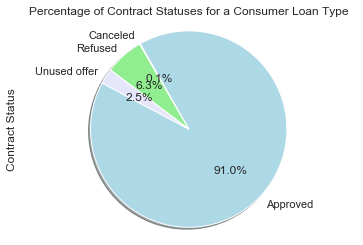

Consumer Loans had a 93.5% approval rate compared to the Cash Loan and Revolving Loan Types.


In [27]:
#Dataframe for consumer loan'PREV_NAME_CONTRACT_TYPE'
consumer_loan_type=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_TYPE'] == "Consumer loans"]

#Dataframe grouping by the 'PREV_NAME_CONTRACT_STATUS' column
consumerloan_status_group = consumer_loan_type.groupby('PREV_NAME_CONTRACT_STATUS')

#dataframe counting the number of data points for each contract status type
consumerloan_status_group_count = pd.DataFrame(consumerloan_status_group['PREV_NAME_CONTRACT_STATUS'].count())

#Labels for pie chart
consumerloan_statuses = list(consumerloan_status_group_count.index.values)
consumerloan_statuses_count = consumerloan_status_group_count['PREV_NAME_CONTRACT_STATUS']

#The colors of each section of the pie chart
colors = ["lightblue", "pink", "lightgreen", "lavender"]

#Create the pie chart based on values
plt.pie(consumerloan_statuses_count, labels=consumerloan_statuses, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=152)
plt.rcParams['font.size'] = 13
plt.title("Percentage of Contract Statuses for a Consumer Loan Type")
plt.ylabel("Contract Status")
plt.axis("equal")
plt.savefig("Images/ConsumerloanStatusesPieChart.png")
plt.show()

print(f"Consumer Loans had a 93.5% approval rate compared to the Cash Loan and Revolving Loan Types.")

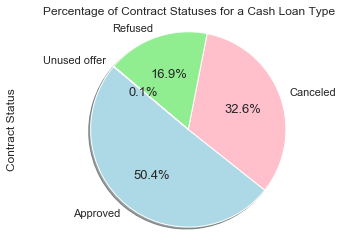

In [28]:
#Dataframe for cash loan'PREV_NAME_CONTRACT_TYPE'
cash_loan_type=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_TYPE'] == "Cash loans"]

#Dataframe grouping by the 'PREV_NAME_CONTRACT_STATUS' column
cashloan_status_group = cash_loan_type.groupby('PREV_NAME_CONTRACT_STATUS')

#dataframe counting the number of data points for each contract status type
cashloan_status_group_count = pd.DataFrame(cashloan_status_group['PREV_NAME_CONTRACT_STATUS'].count())

#Labels for pie chart
cashloan_statuses = list(cashloan_status_group_count.index.values)
cashloan_statuses_count = cashloan_status_group_count['PREV_NAME_CONTRACT_STATUS']

#The colors of each section of the pie chart
colors = ["lightblue", "pink", "lightgreen", "lavender"]

#Create the pie chart based on values
plt.pie(cashloan_statuses_count, labels=cashloan_statuses, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.rcParams['font.size'] = 13
plt.title("Percentage of Contract Statuses for a Cash Loan Type")
plt.ylabel("Contract Status")
plt.axis("equal")

plt.savefig("Images/CashloanStatusesPieChart.png")
plt.show()

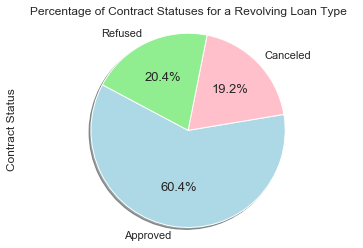

In [29]:
#Dataframe for revolving loan'PREV_NAME_CONTRACT_TYPE'
revolving_loan_type=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_TYPE'] == "Revolving loans"]

#Dataframe grouping by the 'PREV_NAME_CONTRACT_STATUS' column
revolvingloan_status_group = revolving_loan_type.groupby('PREV_NAME_CONTRACT_STATUS')

#dataframe counting the number of data points for each contract status type
revolvingloan_status_group_count = pd.DataFrame(revolvingloan_status_group['PREV_NAME_CONTRACT_STATUS'].count())

#Labels for pie chart
revolvingloan_statuses = list(revolvingloan_status_group_count.index.values)
revolvingloan_statuses_count = revolvingloan_status_group_count['PREV_NAME_CONTRACT_STATUS']

#The colors of each section of the pie chart
colors = ["lightblue", "pink", "lightgreen", "lavender"]

#Create the pie chart based on values
plt.pie(revolvingloan_statuses_count, labels=revolvingloan_statuses, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=152)
plt.rcParams['font.size'] = 13
plt.title("Percentage of Contract Statuses for a Revolving Loan Type")
plt.ylabel("Contract Status")
plt.axis("equal")
plt.savefig("Images/RevolvingloanStatusesPieChart.png")
plt.show()

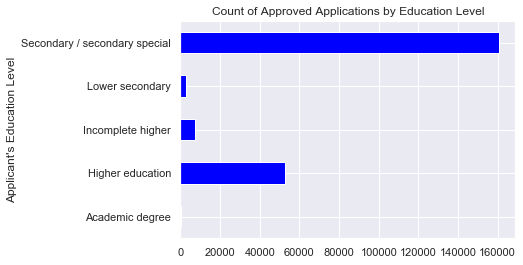

Most applicants who were approved had a secondary or special secondary educational background.
There was a total of 160,874 approved apps for those with secondary/special secondary education level.


In [30]:
#Dataframe for approved which is (approved and unused offer) loans using 'PREV_NAME_CONTRACT_STATUS' column

approved_loans=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_STATUS'].isin(['Approved','Unused offer'])]
                                                   
#Creating a dataframe grouping by the column 'CURR_NAME_EDUCATION_TYPE'
education_group = approved_loans.groupby('CURR_NAME_EDUCATION_TYPE')

#Record count number of data points for each education level
education_group_count = pd.DataFrame(education_group['CURR_NAME_EDUCATION_TYPE'].count())

#Create bar graph
approvedloan_education_chart = education_group_count.plot(kind='barh', title="Count of Approved Applications by Education Level", color="blue", legend=None)
# Set the ylabel using class methods
approvedloan_education_chart.set_ylabel("Applicant's Education Level")

# Save the figure
plt.savefig("Images/ApprovedbyEducationBarChart.png")
plt.show()

print(f"Most applicants who were approved had a secondary or special secondary educational background.")
print(f"There was a total of 160,874 approved apps for those with secondary/special secondary education level.")

      

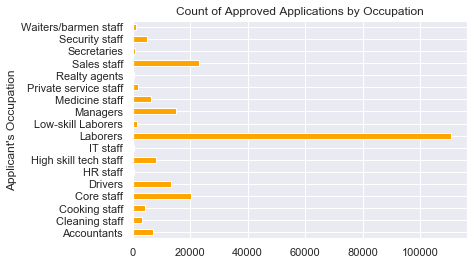

Most applicants who were approved were Laborers.
40,726 laborers had their loan application approved.


In [31]:
#Creating a dataframe grouping by the column 'CURR_OCCUPATION_TYPE'
occupation_group = approved_loans.groupby('CURR_OCCUPATION_TYPE')

#Record count number of data points for each occupation
occupation_group_count=pd.DataFrame(occupation_group['CURR_OCCUPATION_TYPE'].count())

#Create bar graph
approvedloan_occupation_chart = occupation_group_count.plot(kind='barh', title="Count of Approved Applications by Occupation", color="orange", legend=None)
# Set the ylabel using class methods
approvedloan_occupation_chart.set_ylabel("Applicant's Occupation")

#grouped = df.groupby('mygroups').sum().reset_index()
#grouped.sort_values('mygroups', ascending=False)

# Save the figure
plt.savefig("Images/ApprovedbyOccupationBarChart.png")
plt.show()
print(f"Most applicants who were approved were Laborers.")
print(f"40,726 laborers had their loan application approved.")

In [32]:
occupation_group_count


,CURR_OCCUPATION_TYPE
CURR_OCCUPATION_TYPE,
Accountants,7198
Cleaning staff,3355
Cooking staff,4454
Core staff,20139
Drivers,13463
HR staff,403
High skill tech staff,8215
IT staff,357
Laborers,110939


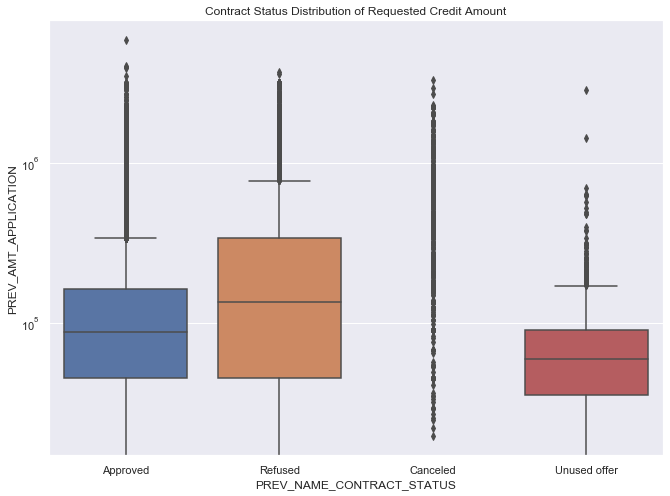

The requested credit amounts are all normally distributed excluding the unused offer status because of the low count of data points.
The median requested credit amount for approved contracts is 87714.0 rupees.
The median requested credit amount for refused contracts is  135000.0 rupees.
It seems that there are a lot of outliers within the Approved status box plot.


In [33]:
#Create boxplot for name

plt.figure(figsize=(11,8))
creditamount_status_boxplot = sns.boxplot(x = 'PREV_NAME_CONTRACT_STATUS' , y = 'PREV_AMT_APPLICATION',data = clean_loan_data)
creditamount_status_boxplot.set_yscale('log')
creditamount_status_boxplot.set_title('Contract Status Distribution of Requested Credit Amount')

plt.savefig("Images/ContractStatusDistBoxPlot.png")
plt.show()

approved_loans2=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_STATUS'].isin(['Approved'])]
refused_loans=clean_loan_data.loc[clean_loan_data['PREV_NAME_CONTRACT_STATUS'].isin(['Refused'])]

approved_amount_median=approved_loans2['PREV_AMT_APPLICATION'].median()
refused_amount_median=refused_loans['PREV_AMT_APPLICATION'].median()

print(f"The requested credit amounts are all normally distributed excluding the unused offer status because of the low count of data points.")
print(f"The median requested credit amount for approved contracts is {approved_amount_median} rupees.")
print(f"The median requested credit amount for refused contracts is  {refused_amount_median} rupees.")
print(f"It seems that there are a lot of outliers within the Approved status box plot.")

In [34]:
age_df= clean_loan_data[["SK_ID_CURR","AGE","AGE RANGE","PREV_NAME_CONTRACT_STATUS"]]
conditions = [(age_df["PREV_NAME_CONTRACT_STATUS"] == 'Approved'),(age_df["PREV_NAME_CONTRACT_STATUS"] == 'Canceled'),(age_df["PREV_NAME_CONTRACT_STATUS"] =='Refused'),(age_df["PREV_NAME_CONTRACT_STATUS"] =='Unused offer')]
values = [1,0,0,1]
age_df['APPROVAL COUNT'] = np.select(conditions,values)

#approved_agesummary_df = age_df.loc[age_df["PREV_NAME_CONTRACT_STATUS"]=="Approved", :]
agesum_summary_df = age_df.groupby(['AGE RANGE'], as_index=False).agg({"APPROVAL COUNT": sum})
agecount_summary_df = age_df.groupby(['AGE RANGE'], as_index=False).agg({"APPROVAL COUNT": "count"})
merge_df = pd.merge(agesum_summary_df, agecount_summary_df, on="AGE RANGE")
merge_df = merge_df.rename(columns={"APPROVAL COUNT_x":"Approvals", "APPROVAL COUNT_y":"Applications"})
merge_df['Rejections'] = merge_df['Applications'] - merge_df['Approvals']

merge_df['Approval Rate'] =(merge_df['Approvals']/merge_df['Applications']).astype(float)


C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


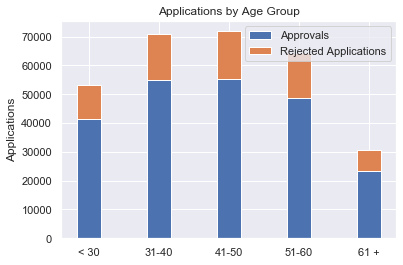

There is no direct correlation between age and approval rates. The average approval rate accross all age ranges is 77%


In [35]:
labels = ['< 30', '31-40', '41-50', '51-60', '61 +']
approvals = merge_df['Approvals']
rejections = merge_df['Rejections']

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, approvals, width, label='Approvals')
ax.bar(labels, rejections, width, bottom=approvals,
       label='Rejected Applications')

ax.set_ylabel('Applications')
ax.set_title('Applications by Age Group')
ax.legend()

plt.savefig("Images/ApplicantsbyAgeGroupBarPlot.png")
plt.show()

print("There is no direct correlation between age and approval rates. The average approval rate accross all age ranges is 77%")

In [36]:
import csv
import quandl
#from api_keys_project1 import stock_api_key
#quandl.ApiConfig.api_key = stock_api_key

quandl.ApiConfig.api_key = "He_gAqaLmRXFqjy82dw6"

BSE500 = quandl.get('BSE/BSE500',start_date ="2019-01-01",end_date="2019-12-31")

BSE500data= pd.concat([BSE500.head(1), BSE500.tail(1)])
BSE500data['Open'] = BSE500data['Open'].astype(int)
BSE500data['Open'].round(0)
BSE500data['High'] = BSE500data['High'].astype(int)
BSE500data['High'].round(0)
BSE500data['Low'] = BSE500data['Low'].astype(int)
BSE500data['Low'].round(0)
BSE500data['Close'] = BSE500data['Close'].astype(int)
BSE500data['Close'].round(0)

BSE500ly = quandl.get('BSE/BSE500',start_date ="2018-01-01",end_date="2018-12-31")

BSE500dataly= pd.concat([BSE500ly.head(1), BSE500ly.tail(1)])
BSE500dataly['Open'] = BSE500dataly['Open'].astype(int)
BSE500dataly['Open'].round(0)
BSE500dataly['High'] = BSE500dataly['High'].astype(int)
BSE500dataly['High'].round(0)
BSE500dataly['Low'] = BSE500dataly['Low'].astype(int)
BSE500dataly['Low'].round(0)
BSE500dataly['Close'] = BSE500dataly['Close'].astype(int)
BSE500dataly['Close'].round(0)


openpricety= BSE500data.loc["2019-01-01", "Open"]
closepricety= BSE500data.loc["2019-12-31", "Close"]
yearlypctchangety =(openpricety/closepricety)-1

openpricely= BSE500dataly.loc["2018-01-01", "Open"]
closepricely= BSE500dataly.loc["2018-12-31", "Close"]
yearlypctchangely =(openpricely/closepricely)-1
print(yearlypctchangety)
print(yearlypctchangely)

-0.06989212995468186
0.03301237964236581


In [37]:
question6_df= clean_loan_data[["SK_ID_CURR","PREV_DAYS_DECISION","PREV_NAME_CONTRACT_STATUS"]]
crit_period = (question6_df.PREV_DAYS_DECISION < -365) & (question6_df.PREV_DAYS_DECISION > -730)
question6_df = question6_df[crit_period]

conditions = [(question6_df["PREV_NAME_CONTRACT_STATUS"] == 'Approved'),(question6_df["PREV_NAME_CONTRACT_STATUS"] == 'Canceled'),(question6_df["PREV_NAME_CONTRACT_STATUS"] =='Refused'),(question6_df["PREV_NAME_CONTRACT_STATUS"] =='Unused offer')]
values = [1,0,0,1]
question6_df['APPROVAL COUNT'] = np.select(conditions,values)

agesum2_summary_df = question6_df.groupby(['PREV_NAME_CONTRACT_STATUS'], as_index=False).agg({"APPROVAL COUNT": sum})
agecount2_summary_df = question6_df.groupby(['PREV_NAME_CONTRACT_STATUS'], as_index=False).agg({"APPROVAL COUNT": "count"})
merge2_df = pd.merge(agesum2_summary_df, agecount2_summary_df, on="PREV_NAME_CONTRACT_STATUS")
merge2_df = merge2_df.rename(columns={"APPROVAL COUNT_x":"Approvals", "APPROVAL COUNT_y":"Applications"})
merge2_df['Rejections'] = merge2_df['Applications'] - merge2_df['Approvals']

question6a_df= clean_loan_data[["SK_ID_CURR","PREV_DAYS_DECISION","PREV_NAME_CONTRACT_STATUS"]]
crit2_period = (question6a_df.PREV_DAYS_DECISION < 0) & (question6a_df.PREV_DAYS_DECISION > -365)
question7_df = question6a_df[crit2_period]

conditions = [(question7_df["PREV_NAME_CONTRACT_STATUS"] == 'Approved'),(question7_df["PREV_NAME_CONTRACT_STATUS"] == 'Canceled'),(question7_df["PREV_NAME_CONTRACT_STATUS"] =='Refused'),(question7_df["PREV_NAME_CONTRACT_STATUS"] =='Unused offer')]
values = [1,0,0,1]
question7_df['APPROVAL COUNT'] = np.select(conditions,values)

agesum1_summary_df = question7_df.groupby(['PREV_NAME_CONTRACT_STATUS'], as_index=False).agg({"APPROVAL COUNT": sum})
agecount1_summary_df = question7_df.groupby(['PREV_NAME_CONTRACT_STATUS'], as_index=False).agg({"APPROVAL COUNT": "count"})
merge1_df = pd.merge(agesum1_summary_df, agecount1_summary_df, on="PREV_NAME_CONTRACT_STATUS")
merge1_df = merge1_df.rename(columns={"APPROVAL COUNT_x":"Approvals", "APPROVAL COUNT_y":"Applications"})
merge1_df['Rejections'] = merge1_df['Applications'] - merge1_df['Approvals']

mergef_df = pd.merge(merge1_df, merge2_df, on="PREV_NAME_CONTRACT_STATUS")
mergef_df = mergef_df.rename(columns={"Approvals_x":"2019 Approvals","Rejections_x":"2019 Rejections", "Applications_x":"2019 Applications","Approvals_y":"2018 Approvals","Rejections_y":"2018 Rejections", "Applications_y":"2018 Applications"})
mergef_df['app%ty']=mergef_df['2019 Approvals']/mergef_df['2019 Applications'].sum()
mergef_df['app%ly']=mergef_df['2018 Approvals']/mergef_df['2018 Applications'].sum()
mergef_df

finaltyapprate = mergef_df['app%ty'].sum()
finallyapprate = mergef_df['app%ly'].sum()


data = [['2018',finallyapprate,yearlypctchangely], ['2019',finaltyapprate,yearlypctchangety]] 
  

api_df = pd.DataFrame(data, columns = ['Year', 'Approval Rate','Market Performance']) 
api_df

C:\Users\Brian\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Year,Approval Rate,Market Performance
0,2018,0.829387,0.033012
1,2019,0.519786,-0.069892


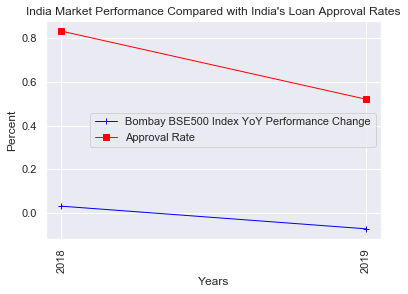

While there is direct correlation between market performance and approval rates there is not enough data to support market performance influences loans approval rates.


In [38]:
x_axis = np.arange(len(api_df))
tick_locations = [value for value in x_axis]

points_stock = api_df['Market Performance']
points_approval = api_df['Approval Rate']
stock = plt.plot(x_axis, points_stock, marker="+",color="blue", linewidth=1, label="Bombay BSE500 Index YoY Performance Change")
approval= plt.plot(x_axis, points_approval, marker="s", color="Red", linewidth=1, label="Approval Rate")
plt.legend(loc="best")
plt.xticks(tick_locations,api_df["Year"], rotation="vertical")
plt.xlabel("Years")
plt.ylabel("Percent")
plt.title("India Market Performance Compared with India's Loan Approval Rates")

plt.savefig("Images/IndiaMarketPerformaceLinePlot.png")
plt.show()

print("While there is direct correlation between market performance and approval rates there is not enough data to support market performance influences loans approval rates.")


In [39]:
# Create a DataFrame with CURR_AMT_CREDIT (loan amount) with Age Ranges, regardless of approvals
age_data = clean_loan_data[["SK_ID_CURR", 
                            "CURR_AMT_INCOME_TOTAL",
                            "CURR_AMT_CREDIT",
                            "CURR_AMT_ANNUITY",
                            "AGE",
                            "AGE RANGE"]]
age_data.head()

,SK_ID_CURR,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,AGE,AGE RANGE
0,100002,202500.0,406597.5,24700.5,26.0,< 30
1,100003,270000.0,1293502.5,35698.5,46.0,41-50
4,100004,67500.0,135000.0,6750.0,52.0,51-60
5,100006,135000.0,312682.5,29686.5,52.0,51-60
14,100007,121500.0,513000.0,21865.5,55.0,51-60


In [40]:
# Create Age Range Summary of Totals Applicants Per age and income level and loan amount
# Groupby Age Range
age_count_df = age_data.groupby(["AGE RANGE"])
tot_age_count = age_count_df["SK_ID_CURR"].nunique()

# Average Loan Amount by Age
avg_loan_by_age = round(age_count_df["CURR_AMT_CREDIT"].mean(),0)

# Average Income Amount by Age
avg_income_by_age = round(age_count_df["CURR_AMT_INCOME_TOTAL"].mean(),0)

# Summary Data Frame of Age Range

age_summary = pd.DataFrame({"Loan Applicant Count by Age": tot_age_count,
                           "Average Income": avg_income_by_age,
                           "Average Loan Amount": avg_loan_by_age})
age_summary

,Loan Applicant Count by Age,Average Income,Average Loan Amount
AGE RANGE,,,
< 30,53288,160153.0,483478.0
31-40,70885,177234.0,598472.0
41-50,71850,178797.0,652040.0
51-60,64306,162919.0,639730.0
61 +,30728,137447.0,514612.0


In [41]:
# For Scatter Plot DataFrame - Need Age Only and not Age Range for Plotting
age_only = clean_loan_data[["SK_ID_CURR", 
                            "CURR_AMT_INCOME_TOTAL",
                            "CURR_AMT_CREDIT",
                            "CURR_AMT_ANNUITY",
                            "AGE"]]
age_only.head()

,SK_ID_CURR,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,AGE
0,100002,202500.0,406597.5,24700.5,26.0
1,100003,270000.0,1293502.5,35698.5,46.0
4,100004,67500.0,135000.0,6750.0,52.0
5,100006,135000.0,312682.5,29686.5,52.0
14,100007,121500.0,513000.0,21865.5,55.0


In [42]:
# Change data type for AGE series, for groupby function
age_only['AGE'].astype('category')

0          26.0
1          46.0
4          52.0
5          52.0
14         55.0
           ... 
1413687    26.0
1413688    57.0
1413689    41.0
1413691    33.0
1413693    46.0
Name: AGE, Length: 291057, dtype: category
Categories (49, float64): [21.0, 22.0, 23.0, 24.0, ..., 66.0, 67.0, 68.0, 69.0]

In [43]:
# Create Age Only Summary for Scatter Plot
agecount = age_only.groupby(["AGE"])
totagecount = agecount["AGE"].nunique()

# Average Loan Amount by Age
avgloan = round(agecount["CURR_AMT_CREDIT"].mean(),0)

# Average Income Amount by Age
avgincome = round(agecount["CURR_AMT_INCOME_TOTAL"].mean(),0)

# Summary Data Frame of Age Range

age_only_summary = pd.DataFrame({"Average Income by Age Group": avgincome,
                           "Average Loan Amount by Age Group": avgloan})
age_only_summary

,Average Income by Age Group,Average Loan Amount by Age Group
AGE,,
21.0,118494.0,232053.0
22.0,133040.0,346190.0
23.0,145010.0,417611.0
24.0,149373.0,425487.0
25.0,154627.0,438375.0
26.0,156833.0,460717.0
27.0,160288.0,486419.0
28.0,162030.0,492819.0
29.0,165848.0,511979.0


In [44]:
# Reset age_only_summary dataframe Index for scatter plot

age_only_summary.reset_index(level=0, inplace=True)
age_only_summary

,AGE,Average Income by Age Group,Average Loan Amount by Age Group
0,21.0,118494.0,232053.0
1,22.0,133040.0,346190.0
2,23.0,145010.0,417611.0
3,24.0,149373.0,425487.0
4,25.0,154627.0,438375.0
5,26.0,156833.0,460717.0
6,27.0,160288.0,486419.0
7,28.0,162030.0,492819.0
8,29.0,165848.0,511979.0
9,30.0,169070.0,525107.0


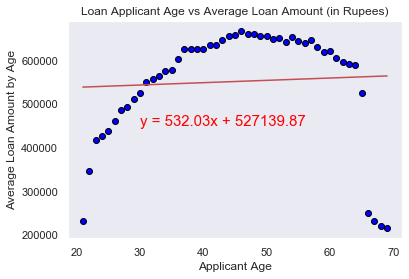

----------------------------------------------------------------------------------
Obeservation: Average loan increased with age.
Obeservation: At about age 55, the average loans decrease with an increase in age.


In [45]:
import scipy.stats as st
from scipy.stats import linregress
# CORRELATION AND REGRESSION LINE
# Generate a scatter plot age vs average loan amount
x_values = age_only_summary["AGE"]
y_values = age_only_summary["Average Loan Amount by Age Group"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, marker='o', facecolor='blue', edgecolor='black')
plt.plot(x_values, regress_values, 'r-')
plt.annotate(line_eq,(30,450000), fontsize=15, color='red')
plt.title("Loan Applicant Age vs Average Loan Amount (in Rupees)")
plt.xlabel("Applicant Age")
plt.ylabel("Average Loan Amount by Age")
plt.grid()

plt.savefig("Images/AgeAvgLoanScatterPlot.png")
plt.show()

print('----------------------------------------------------------------------------------')
print("Obeservation: Average loan increased with age.")
print("Obeservation: At about age 55, the average loans decrease with an increase in age.")

In [46]:
# Save Scatter Plot image
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [47]:
df_status = clean_loan_data[["PREV_NAME_CONTRACT_STATUS","CURR_AMT_CREDIT"]]
df_status.groupby(by='PREV_NAME_CONTRACT_STATUS').describe()

CURR_AMT_CREDIT                                \
                                    count           mean            std   
PREV_NAME_CONTRACT_STATUS                                                 
Approved                         219623.0  595664.074093  396254.443915   
Canceled                          35064.0  590383.459959  384402.363597   
Refused                           31948.0  559669.857769  366291.224740   
Unused offer                       4422.0  584281.833786  385808.383726   

                                                                             
                               min       25%       50%       75%        max  
PREV_NAME_CONTRACT_STATUS                                                    
Approved                   45000.0  270000.0  513531.0  808650.0  4050000.0  
Canceled                   45000.0  276277.5  510012.0  808650.0  2695500.0  
Refused                    45000.0  270000.0  481495.5  755190.0  3150000.0  
Unused offer               45000.0  270000.0  500458.5  808650.0  2695500.0

In [48]:
print("There is no correlation between the credit amount request and wheter it was approved or not.")

There is no correlation between the credit amount request and wheter it was approved or not.


In [49]:
frame_df = pd.DataFrame({
    "": ["Approved", "Unapproved", "Total"],
    "Number of Loans": [224045, 67012, 291057],
    "Percentage": [77, 23, 100]
})
print(frame_df)
print("The overall approval rate was 77 percent")

               Number of Loans  Percentage
0    Approved           224045          77
1  Unapproved            67012          23
2       Total           291057         100
The overall approval rate was 77 percent


In [50]:
clean_loan_data.head()




,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,PREV_NAME_YIELD_GROUP,PREV_PRODUCT_COMBINATION,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL,AGE,AGE RANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0,26.0,< 30
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0,46.0,41-50
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0,52.0,51-60
5,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0,52.0,51-60
14,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,high,Cash Street: high,365243.0,-834.0,-324.0,-354.0,-347.0,0.0,55.0,51-60


In [51]:
clean_loan_data['CURR_OCCUPATION_TYPE'].value_counts()

Laborers                 143964
Sales staff               30587
Core staff                25671
Managers                  19650
Drivers                   17730
High skill tech staff     10512
Accountants                9159
Medicine staff             8215
Security staff             6470
Cooking staff              5777
Cleaning staff             4526
Private service staff      2545
Low-skill Laborers         2031
Waiters/barmen staff       1302
Secretaries                1242
Realty agents               718
HR staff                    515
IT staff                    443
Name: CURR_OCCUPATION_TYPE, dtype: int64

In [52]:
clean_loan_data.dtypes

SK_ID_CURR                            int64
CURR_TARGET                           int64
CURR_NAME_CONTRACT_TYPE              object
CURR_CODE_GENDER                     object
CURR_FLAG_OWN_CAR                    object
CURR_FLAG_OWN_REALTY                 object
CURR_CNT_CHILDREN                     int64
CURR_AMT_INCOME_TOTAL               float64
CURR_AMT_CREDIT                     float64
CURR_AMT_ANNUITY                    float64
CURR_AMT_GOODS_PRICE                float64
CURR_NAME_INCOME_TYPE                object
CURR_NAME_EDUCATION_TYPE             object
CURR_NAME_FAMILY_STATUS              object
CURR_NAME_HOUSING_TYPE               object
CURR_REGION_POPULATION_RELATIVE     float64
CURR_DAYS_BIRTH                       int64
CURR_OCCUPATION_TYPE                 object
CURR_CNT_FAM_MEMBERS                float64
CURR_REGION_RATING_CLIENT             int64
CURR_WEEKDAY_APPR_PROCESS_START      object
CURR_ORGANIZATION_TYPE               object
CURR_OBS_30_CNT_SOCIAL_CIRCLE   

### Let's prepare our data a bit more to run some machine learning models. We will remove the metrics from the clean_loan_data dataframe that are not critical to running our models.

In [53]:

clean_loan_data.drop('PREV_SK_ID_PREV', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_CONTRACT_TYPE', axis=1, inplace=True)
clean_loan_data.drop('PREV_AMT_ANNUITY', axis=1, inplace=True)

clean_loan_data.drop('PREV_AMT_CREDIT', axis=1, inplace=True)
clean_loan_data.drop('PREV_AMT_DOWN_PAYMENT', axis=1, inplace=True)
clean_loan_data.drop('PREV_AMT_GOODS_PRICE', axis=1, inplace=True)
clean_loan_data.drop('PREV_WEEKDAY_APPR_PROCESS_START', axis=1, inplace=True)
clean_loan_data.drop('PREV_NFLAG_LAST_APPL_IN_DAY', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_CASH_LOAN_PURPOSE', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_DECISION', axis=1, inplace=True)
clean_loan_data.drop('PREV_CODE_REJECT_REASON', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_CLIENT', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_GOODS_CATEGORY', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_PORTFOLIO', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_PRODUCT_TYPE', axis=1, inplace=True)
clean_loan_data.drop('PREV_CHANNEL_TYPE', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_SELLER_INDUSTRY', axis=1, inplace=True)
clean_loan_data.drop('PREV_NAME_YIELD_GROUP', axis=1, inplace=True)
clean_loan_data.drop('PREV_PRODUCT_COMBINATION', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_FIRST_DRAWING', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_FIRST_DUE', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_LAST_DUE_1ST_VERSION', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_LAST_DUE', axis=1, inplace=True)
clean_loan_data.drop('PREV_DAYS_TERMINATION', axis=1, inplace=True)
clean_loan_data.drop('PREV_NFLAG_INSURED_ON_APPROVAL', axis=1, inplace=True)
clean_loan_data.drop('CURR_WEEKDAY_APPR_PROCESS_START', axis=1, inplace=True)
clean_loan_data.drop('CURR_ORGANIZATION_TYPE', axis=1, inplace=True)
clean_loan_data.drop('CURR_OBS_30_CNT_SOCIAL_CIRCLE', axis=1, inplace=True)
clean_loan_data.drop('CURR_DEF_30_CNT_SOCIAL_CIRCLE', axis=1, inplace=True)
clean_loan_data.drop('CURR_OBS_60_SOCIAL_CIRCLE', axis=1, inplace=True)
clean_loan_data.drop('CURR_DEF_60_SOCIAL_CIRCLE', axis=1, inplace=True)
clean_loan_data.drop('CURR_AMT_REQ_CREDIT_BUREAU_MON', axis=1, inplace=True)
clean_loan_data.drop('CURR_AMT_REQ_CREDIT_BUREAU_YEAR', axis=1, inplace=True)
clean_loan_data.drop('CURR_AMT_GOODS_PRICE', axis=1, inplace=True)
clean_loan_data.drop('AGE RANGE', axis=1, inplace=True)


C:\Users\Brian\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
#lets convert the remaining metrics that are strings to numeric values so we can run our models
CURR_NAME_CONTRACT_TYPE = {'Cash loans': 0, 'Revolving loans': 1}
clean_loan_data.CURR_NAME_CONTRACT_TYPE = [CURR_NAME_CONTRACT_TYPE[item] for item in clean_loan_data.CURR_NAME_CONTRACT_TYPE]

CURR_CODE_GENDER = {'M':0, 'F':1, 'XNA':2}
clean_loan_data.CURR_CODE_GENDER=[CURR_CODE_GENDER[item] for item in clean_loan_data.CURR_CODE_GENDER]


CURR_FLAG_OWN_CAR = {'N':0, 'Y':1}
clean_loan_data.CURR_FLAG_OWN_CAR=[CURR_FLAG_OWN_CAR[item] for item in clean_loan_data.CURR_FLAG_OWN_CAR]

CURR_FLAG_OWN_REALTY = {'N':0, 'Y':1}
clean_loan_data.CURR_FLAG_OWN_REALTY=[CURR_FLAG_OWN_REALTY[item] for item in clean_loan_data.CURR_FLAG_OWN_REALTY]


CURR_NAME_INCOME_TYPE = {'Businessman':0, 'Commercial associate':1, 'Maternity leave':2, 'Pensioner':3, 'State servant':4,'Student':5, 'Unemployed':6, 'Working':7}
clean_loan_data.CURR_NAME_INCOME_TYPE=[CURR_NAME_INCOME_TYPE[item] for item in clean_loan_data.CURR_NAME_INCOME_TYPE]


CURR_NAME_EDUCATION_TYPE = {'Academic degree':0, 'Higher education':1, 'Incomplete higher':2, 'Lower secondary':3, 'Secondary / secondary special':4}
clean_loan_data.CURR_NAME_EDUCATION_TYPE=[CURR_NAME_EDUCATION_TYPE[item] for item in clean_loan_data.CURR_NAME_EDUCATION_TYPE]


CURR_NAME_FAMILY_STATUS = {'Civil marriage':0, 'Married':1, 'Separated':2, 'Single / not married':3, 'Unknown':4,'Widow':5}
clean_loan_data.CURR_NAME_FAMILY_STATUS=[CURR_NAME_FAMILY_STATUS[item] for item in clean_loan_data.CURR_NAME_FAMILY_STATUS]


CURR_NAME_HOUSING_TYPE = {'Co-op apartment':0, 'House / apartment':1, 'Municipal apartment':2, 'Office apartment':3, 'Rented apartment':4,'With parents':5}
clean_loan_data.CURR_NAME_HOUSING_TYPE=[CURR_NAME_HOUSING_TYPE[item] for item in clean_loan_data.CURR_NAME_HOUSING_TYPE]


CURR_OCCUPATION_TYPE = {'Accountants':0, 'Cleaning staff':1, 'Cooking staff':2, 'Core staff':3, 'Drivers':4,'High skill tech staff':5, 'HR staff':6, 'IT staff':7, 'Laborers':8, 'Low-skill Laborers':9, 'Managers':10, 'Medicine staff':11, 'Private service staff':12, 'Realty agents':13, 'Sales staff':14, 'Secretaries':15, 'Security staff':16, 'Waiters/barmen staff':17}
clean_loan_data.CURR_OCCUPATION_TYPE=[CURR_OCCUPATION_TYPE[item] for item in clean_loan_data.CURR_OCCUPATION_TYPE]

PREV_NAME_CONTRACT_STATUS = {'Refused':0, 'Approved':1, 'Canceled':0, 'Unused offer':1}
clean_loan_data.PREV_NAME_CONTRACT_STATUS=[PREV_NAME_CONTRACT_STATUS[item] for item in clean_loan_data.PREV_NAME_CONTRACT_STATUS]


C:\Users\Brian\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Now that our values are numeric, lets use a histogram visualization to understand if this variable in our model is now evenly distributed after our changes to the data set based on our assumption.


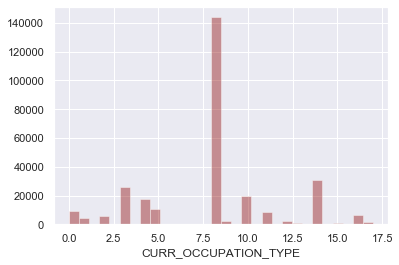

In [55]:


sns.distplot(clean_loan_data['CURR_OCCUPATION_TYPE'],kde=False,color='darkred',bins=30)

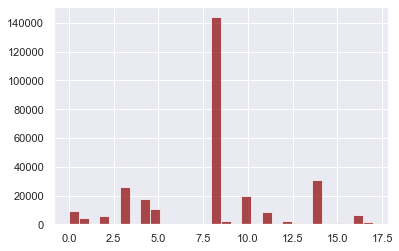

In [56]:
#and a second view:
clean_loan_data['CURR_OCCUPATION_TYPE'].hist(bins=30,color='darkred',alpha=0.7)



### These distibutions make sense when compare to India's most recent census data whose summary states: "Distribution of main workers by industrial category shows that agriculture sector still employs largest number of workers. The dependence on agriculture is brought out by the fact that of the 313 million main workers in the country, 166 million (56.6%) has been engaged in ‘Agricultural and allied activities’."
(https://www.censusindia.gov.in/Census_And_You/economic_activity.aspx#:~:text=In%20terms%20of%20proportion%2C%2068.4,percent%20of%20the%20total%20workers )


In [58]:
clean_loan_data.head()

,SK_ID_CURR,CURR_TARGET,CURR_NAME_CONTRACT_TYPE,CURR_CODE_GENDER,CURR_FLAG_OWN_CAR,CURR_FLAG_OWN_REALTY,CURR_CNT_CHILDREN,CURR_AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,...,CURR_NAME_FAMILY_STATUS,CURR_NAME_HOUSING_TYPE,CURR_REGION_POPULATION_RELATIVE,CURR_DAYS_BIRTH,CURR_OCCUPATION_TYPE,CURR_CNT_FAM_MEMBERS,CURR_REGION_RATING_CLIENT,PREV_AMT_APPLICATION,PREV_NAME_CONTRACT_STATUS,AGE
0,100002,1,0,0,0,1,0,202500.0,406597.5,24700.5,...,3,1,0.018801,-9461,8,1.0,2,179055.0,1,26.0
1,100003,0,0,1,0,0,0,270000.0,1293502.5,35698.5,...,1,1,0.003541,-16765,3,2.0,1,900000.0,1,46.0
4,100004,0,1,0,1,1,0,67500.0,135000.0,6750.0,...,3,1,0.010032,-19046,8,1.0,2,24282.0,1,52.0
5,100006,0,0,1,0,1,0,135000.0,312682.5,29686.5,...,0,1,0.008019,-19005,8,2.0,2,675000.0,1,52.0
14,100007,0,0,0,0,1,0,121500.0,513000.0,21865.5,...,3,1,0.028663,-19932,3,1.0,2,180000.0,1,55.0


In [59]:
clean_loan_data.rename(columns = {'PREV_NAME_CONTRACT_STATUS':'CURR APPROVAL STATUS'}, inplace = True)

C:\Users\Brian\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Statistical Data Analysis

### After performing the Exploratory Data Analysis (EDA) on the data we have the following findings:

### There is no direct correlation between loan approval rates and the loan applicant's age

### The median requested credit amount for approved loans was 88K Rupees. The median requested credit amount for loans that were not approved was 135K Rupees.

### Below we will perform t-tests to confirm which of our EDA findings are statistically significant. More specifically:

### 1) We will perform a t-test on two independent samples: the approved loans with a specific attribute and the approved without it


### 2) We will test the null hypothesis $H_0$ that the approval rate for the two samples is identical.

### 2) The alternative hypothesis $H_a$ would be that the approval rates are different 

### 3) If the t-test results are statistically significant (e.g. p-value > $a, a$ = 0.05), then we will reject the $H_0$ and accept the $H_a$.

In [92]:




#Define the function for a t-test and apply it
def myttest(x,y):
    mean_x = np.mean(x)
    std_x = np.std(x)
    n_x = len(x)
    mean_y = np.mean(y)
    std_y = np.std(y)
    n_y = len(y)
    return ttest_ind_from_stats(mean_x, std_x, n_x, mean_y, std_y, n_y)


In [72]:
#Define the two samples for loans submitted by those younger than 55 years of age and those of all ages. The null hypothesis is that age does not play a factor on whether loans are approved or not. 

approvals1=clean_loan_data['CURR APPROVAL STATUS']
age1=clean_loan_data['AGE']
ageedf = pd.DataFrame (approvals1, age1)
ageedf = ageedf.reset_index()
ageedf['CURR APPROVAL STATUS'] = ageedf['CURR APPROVAL STATUS'].fillna(value = 0)

a = ageedf[ageedf.AGE > 0 ]
a2 = a['CURR APPROVAL STATUS']
a2 =a2.reset_index()
a2array = a2[["CURR APPROVAL STATUS"]].to_numpy()

b = ageedf[ageedf.AGE < 55]
b2 = b['CURR APPROVAL STATUS']
b2 =b2.reset_index()
b2array = b2[["CURR APPROVAL STATUS"]].to_numpy()


#Calculate t-test statistic and p-value
myttest(a2array,b2array)

Ttest_indResult(statistic=14.006224915995286, pvalue=1.455248556248674e-44)

### The p-value of 1.455248556248674e-44 is very small, so we can reject the null hypthesis and confirm that age contribute to a higher approval rate. This does not necessarlity align with our original EDA findings.  


In [74]:

#Define the two samples for loans applications submitted with credit requests in the amount of 88,000 and greater and those submitted with credit request for less

approvals2=clean_loan_data['CURR APPROVAL STATUS']
amount1=clean_loan_data['PREV_AMT_APPLICATION']
amounttdf = pd.DataFrame (approvals1, amount1)
amounttdf = amounttdf.reset_index()
amounttdf['CURR APPROVAL STATUS'] = amounttdf['CURR APPROVAL STATUS'].fillna(value = 0)

aa = amounttdf[amounttdf.PREV_AMT_APPLICATION > 0]
aa2 = aa['CURR APPROVAL STATUS']
aa2 =aa2.reset_index()
aa2array = aa2[["CURR APPROVAL STATUS"]].to_numpy()

bb = amounttdf[amounttdf.PREV_AMT_APPLICATION < 88000]
bb2 = bb['CURR APPROVAL STATUS']
bb2 =bb2.reset_index()
bb2array = bb2[["CURR APPROVAL STATUS"]].to_numpy()



#Calculate t-test statistic and p-value
myttest(aa2array,bb2array)

Ttest_indResult(statistic=-199.389982503635, pvalue=0.0)

### The calculations behind t-values compare your sample mean(s) to the null hypothesis and incorporates both the sample size and the variability in the data. A t-value of 0 indicates that the sample results exactly equal the null hypothesis. As the difference between the sample data and the null hypothesis increases, the absolute value of the t-value increases.
### The larger the absolute value of the t-value, the smaller the p-value, and the greater the evidence against the null hypothesis.
### The p-value of 0.0 is very small, so we can reject the null hypothesis and confirm that the amount of credit requested on the loan application correlates to higher approval rates. This aligns with our original EDA findings.

In [75]:
clean_loan_data.drop('PREV_AMT_APPLICATION', axis=1, inplace=True)

C:\Users\Brian\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


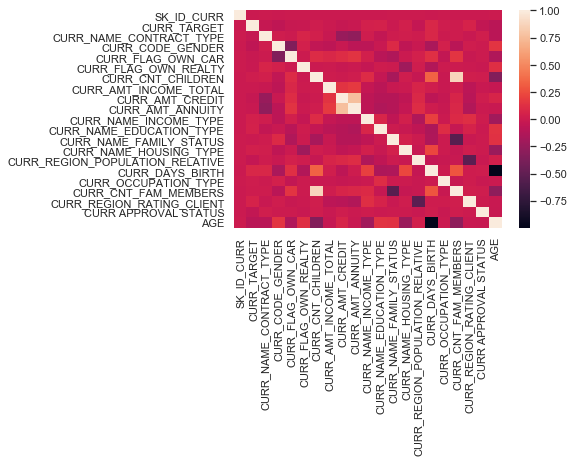

In [77]:
#checking for multicollinearity
corr = clean_loan_data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.autoscale()

## Modeling

In [78]:

data_dummies = pd.get_dummies(clean_loan_data)

In [79]:
#split data into training and test sets
label = clean_loan_data['CURR APPROVAL STATUS']
features = clean_loan_data.drop('CURR APPROVAL STATUS', axis=1)

# Splitting the observations into a training and a testing set for the holdout method

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.30, random_state=46)

In [80]:
# Min-max scaling for neural nets and SVMs
from sklearn import preprocessing
X_train_norm = preprocessing.normalize(X_train, norm='max', axis=0)  # Normalizing across columns
X_test_norm = preprocessing.normalize(X_test, norm='max', axis=0)  # Normalizing across columns

### We are going to look at several classification algorithms and print our reports to see their initial performance
### Logistic Regression

In [81]:
 
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(C=1.0, penalty='l1',solver='liblinear') #,n_jobs=-1
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
X_test_predictions = lm.predict(X_test)
print(classification_report(y_test, X_test_predictions))

0.7689053151335777
              precision    recall  f1-score   support

           0       0.29      0.00      0.00     19947
           1       0.77      1.00      0.87     67371

    accuracy                           0.77     87318
   macro avg       0.53      0.50      0.44     87318
weighted avg       0.66      0.77      0.67     87318



### Decision Tree 

In [82]:

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))
pred = dt.predict(X_test)
print(classification_report(y_test, pred))

0.6422043564900708
              precision    recall  f1-score   support

           0       0.24      0.27      0.26     19947
           1       0.78      0.75      0.76     67371

    accuracy                           0.64     87318
   macro avg       0.51      0.51      0.51     87318
weighted avg       0.66      0.64      0.65     87318



### Random Forest 

In [94]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

0.7710666758285806
              precision    recall  f1-score   support

           0       0.31      0.00      0.00     19947
           1       0.77      1.00      0.87     67371

    accuracy                           0.77     87318
   macro avg       0.54      0.50      0.44     87318
weighted avg       0.67      0.77      0.67     87318



### Our random forest has produced the best f-1 score (0.771) indicating it is potentially the most accurate. Now it is time to plot the ROC score against the baseline to validate the accuracy of the model.

In [85]:
#the model is ready to make predictions on the testing data as follows
# Training predictions (to demonstrate overfitting)
train_rf_predictions = rf.predict(X_train)
train_rf_probs = rf.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [86]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.77 Test: 0.77 Train: 1.0
Roc Baseline: 0.5 Test: 0.55 Train: 1.0


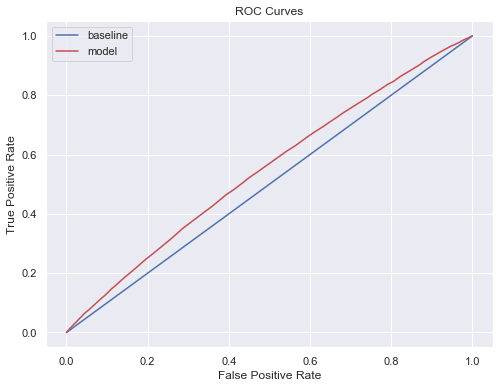

<Figure size 432x288 with 0 Axes>

In [87]:
#train, test, train_labels, test_labels
#X_train, X_test, y_train, y_test

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


### Our ROC Curve is very much in line with the baseline prediction curve further validating the accuracy of the Random Forest model

## Findings

### Let's review top 15 most important features of the models by using sklearn featureimportances

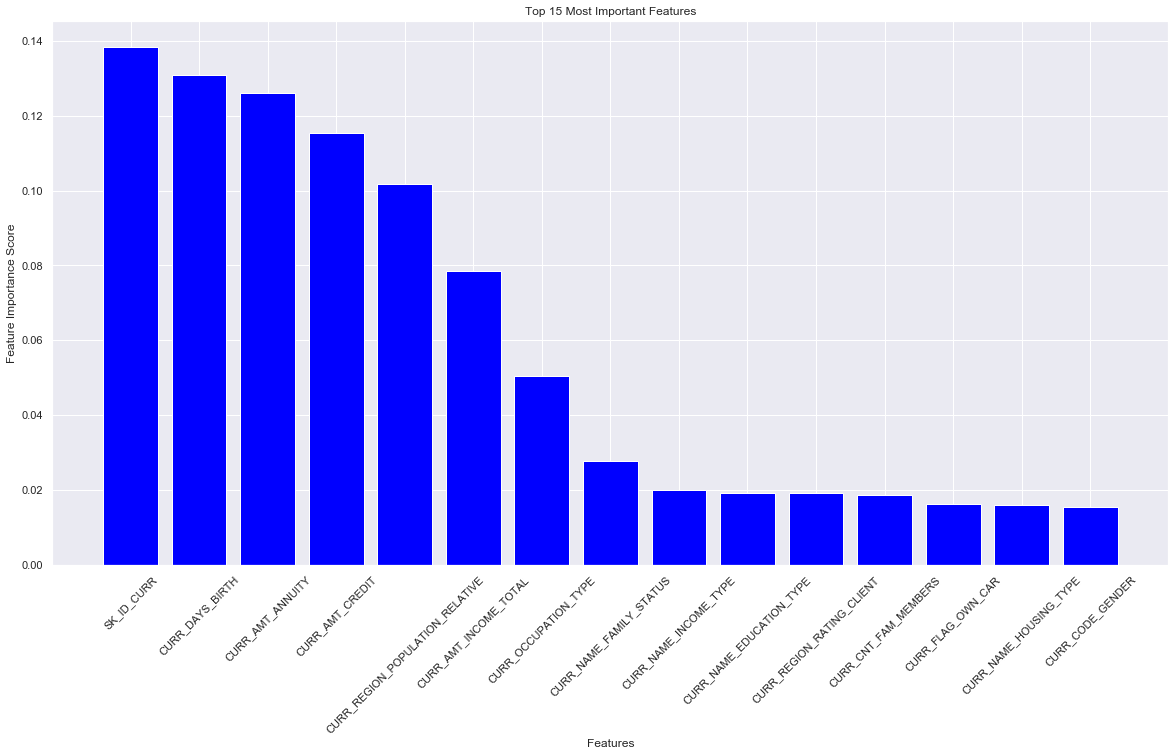

In [88]:

warnings.filterwarnings(action='ignore', category=FutureWarning)

rf.fit(features, label) 
zipped = zip(clean_loan_data.iloc[:,:-2].columns,rf.feature_importances_)
res = sorted(zipped, key = lambda x: x[1], reverse=True)
_ = plt.figure(figsize=(20,10))
for i in res[0:15]:
    _ = plt.bar(i[0],i[1], color='blue')
    _ = plt.title('Top 15 Most Important Features')
    _ = plt.xlabel('Features')
    _ = plt.xticks(rotation=45)
    _ = plt.ylabel('Feature Importance Score')

### Excluding the loan applicant ID we can see that the applicant's age (seen in the metric CURR_DAYS_BIRTH), the amount of the loan (as see through the metrics CURR_AMT_ANNUITY/CREDIT), surprisingly where they are from and finally the applicant's annual income are key factors influencing the prediction outcomes of the random forest model. 